# Praktische Optimierung Blatt 08
### Tobias Lotz:  217856 <br>
### Alexander van der Staay:  185444

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared
from gplearn.genetic import SymbolicRegressor
import graphviz

In [2]:
np.random.seed(0)

### Aufgabe 8.1 a)

In [11]:
def f1(x): return 10 - x * np.cos(x)

LOWER = -10
UPPER = 10

In [12]:
X = np.linspace(LOWER, UPPER, 11).reshape(11, 1)

Text(0, 0.5, '$f(x)$')

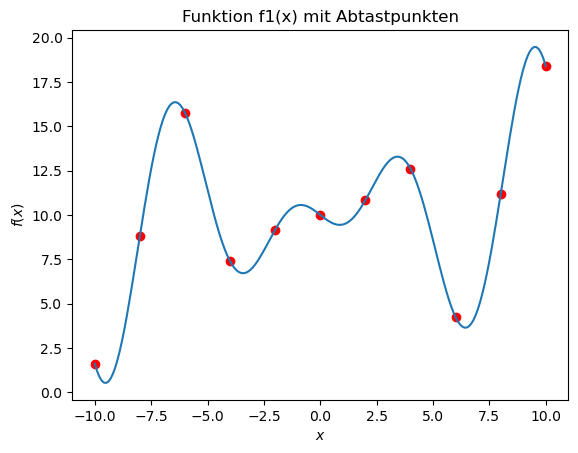

In [6]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse), label="Übersicht")
plt.title("Funktion f1(x) mit Abtastpunkten")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

### (1) Polynomielle Modelle

In [14]:
def poly_model_generator(func, deg, xs=X, ys=None, dim=1):
    poly_feat = PolynomialFeatures(degree=deg, include_bias=True)
    lin_reg = LinearRegression()
    pipe = Pipeline([("polynomial_features", poly_feat), ("linear_regression", lin_reg),])
    pipe.fit(xs, ys)
    return lambda x: pipe.predict(np.array(x).reshape(-1, dim)).flatten()

In [8]:
poly_1 = poly_model_generator(f1, 1, ys=f1(X))
poly_2 = poly_model_generator(f1, 2, ys=f1(X))
poly_5 = poly_model_generator(f1, 5, ys=f1(X))
poly_10 = poly_model_generator(f1, 10, ys=f1(X))
poly_15 = poly_model_generator(f1, 15, ys=f1(X))

In [9]:
degrees = [1, 2, 5, 10, 15]
X_test = np.linspace(LOWER, UPPER, 201)
comp_vals = f1(X_test)
for d in degrees:
    poly_model = poly_model_generator(f1, d, ys=f1(X))
    model_vals = poly_model(X_test)
    total_diff = np.abs(model_vals - comp_vals)
    total_mean = total_diff.mean()
    squared_mean = (total_diff**2).mean()
    print(f'Grade: {d}\tmittlere totale Abweichung: {total_mean : .2f}\tmittlere quadratische Abweichung: {squared_mean : .2f}')

Grade: 1	mittlere totale Abweichung:  3.25	mittlere quadratische Abweichung:  18.02
Grade: 2	mittlere totale Abweichung:  3.25	mittlere quadratische Abweichung:  18.02
Grade: 5	mittlere totale Abweichung:  2.38	mittlere quadratische Abweichung:  8.66
Grade: 10	mittlere totale Abweichung:  2.45	mittlere quadratische Abweichung:  22.20
Grade: 15	mittlere totale Abweichung:  1920.82	mittlere quadratische Abweichung:  24090766.49


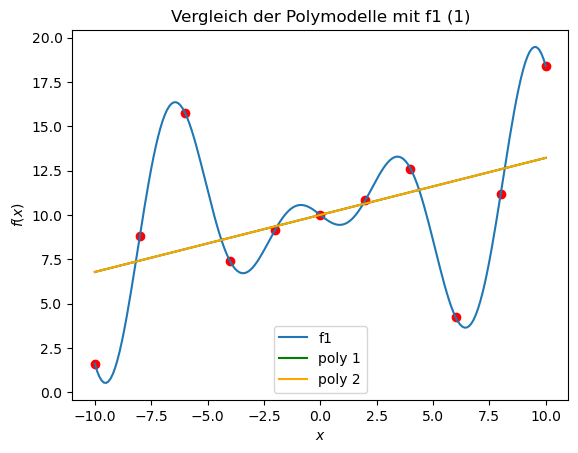

In [10]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, poly_1(X_Achse), c="green")
plt.plot(X_Achse, poly_2(X_Achse), c="orange")
plt.title("Vergleich der Polymodelle mit f1 (1)")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'poly 1', 'poly 2'])

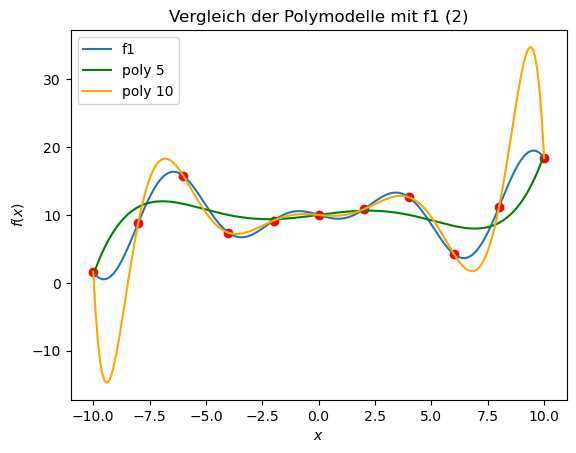

In [11]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, poly_5(X_Achse), c="green")
plt.plot(X_Achse, poly_10(X_Achse), c="orange")
plt.title("Vergleich der Polymodelle mit f1 (2)")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'poly 5', 'poly 10'])

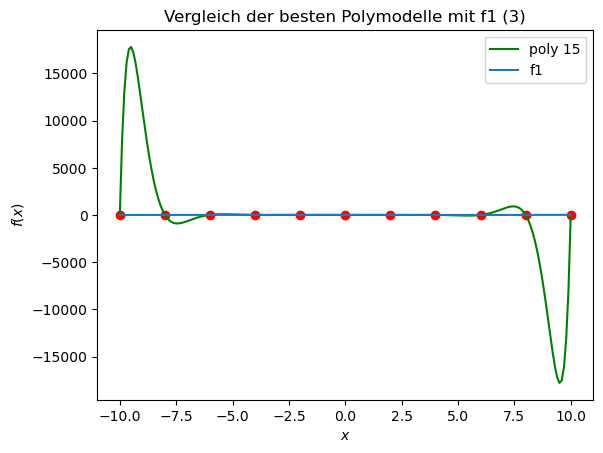

In [12]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, poly_15(X_Achse), c="green")
plt.plot(X_Achse, f1(X_Achse))
plt.title("Vergleich der besten Polymodelle mit f1 (3)")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['poly 15', 'f1'])

Es ist zu erkennen, dass das polynomielle Regressionsmodell mit $Grad=5$ die geringste mittlere Abweichung 
zu der Ursprungsfunktion aufweist. Das nächst beste Modell bzgl. der totalen Abweichung ist das Modell mit $Grad=10$. In Plot (2) ist zu erkennen, dass das Modell mit $Grad=10$ in allen Abtastpunkten genau der Funktion $f_1$ entspricht. Allerdings in der Region $[-10, -8]$ und $[8, 10]$ eine starke Abweichung von $f_1$ aufweist. Das Modell mit $Grad=5$ stimmt nicht in allen Abtastpunkten mit $f_1$ überein, allerdings weicht es auch nicht so stark von $f_1$ ab. Daher weißt es insgesamt eine geringere mittlere Abweichung auf. Die Modelle mit $Grad=1$ und $Grad=2$ scheinen identisch zu sein (siehe Plot (1)), also eine Regressionsgerade. Das Modell mit $Grad=15$ ist deutlich am schlechtesten. Auch dieses weißt erneut eine sehr hohe Abweichung in den Regionen $[-10, -8]$ und $[8, 10]$ auf (siehe Plot (3)).

### (2) Kriging

In [13]:
gpr_rbf = GaussianProcessRegressor(RBF())
gpr_rbf.fit(X, f1(X))

GaussianProcessRegressor(kernel=RBF(length_scale=1))

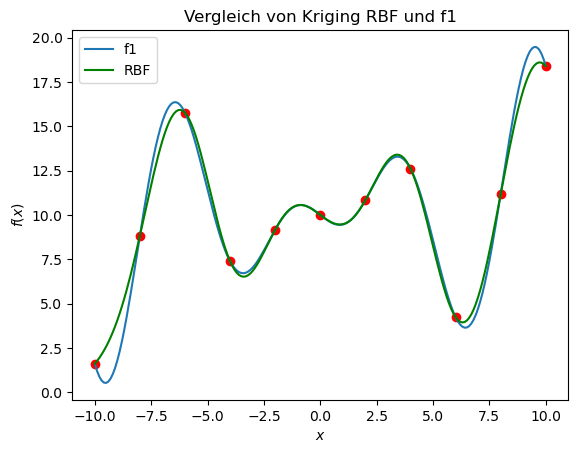

In [14]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, gpr_rbf.predict(X_Achse.reshape(201, 1)), c="green")
plt.title("Vergleich von Kriging RBF und f1")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'RBF'])

In [15]:
total_diff_rbf = np.abs(gpr_rbf.predict(X_test.reshape(201, 1)) - comp_vals)
total_mean_rbf = total_diff_rbf.mean()
squared_mean_rbf = (total_diff_rbf**2).mean()

In [16]:
gpr_mat0 = GaussianProcessRegressor(Matern(nu=0.5))
gpr_mat1 = GaussianProcessRegressor(Matern(nu=1.5))
gpr_mat2 = GaussianProcessRegressor(Matern(nu=2.5))

gpr_mat0.fit(X, f1(X))
gpr_mat1.fit(X, f1(X))
gpr_mat2.fit(X, f1(X))

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5))

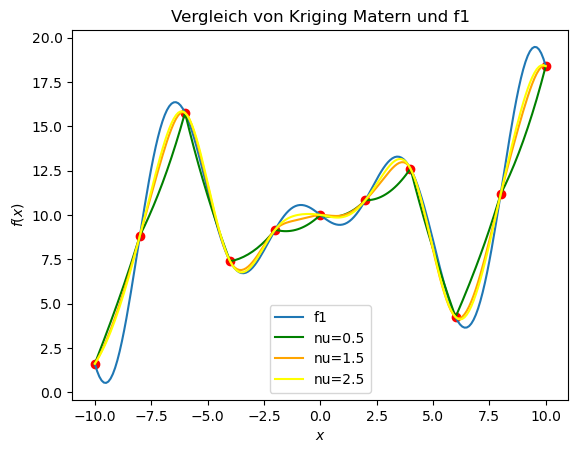

In [17]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, gpr_mat0.predict(X_Achse.reshape(201, 1)), c="green")
plt.plot(X_Achse, gpr_mat1.predict(X_Achse.reshape(201, 1)), c="orange")
plt.plot(X_Achse, gpr_mat2.predict(X_Achse.reshape(201, 1)), c="yellow")
plt.title("Vergleich von Kriging Matern und f1")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'nu=0.5', 'nu=1.5', 'nu=2.5'])

In [18]:
total_diff_mat0 = np.abs(gpr_mat0.predict(X_test.reshape(201, 1)) - comp_vals)
total_diff_mat1 = np.abs(gpr_mat1.predict(X_test.reshape(201, 1)) - comp_vals)
total_diff_mat2 = np.abs(gpr_mat2.predict(X_test.reshape(201, 1)) - comp_vals)

total_mean_mat0   = total_diff_mat0.mean()
squared_mean_mat0 = (total_diff_mat0**2).mean()

total_mean_mat1   = total_diff_mat1.mean()
squared_mean_mat1 = (total_diff_mat1**2).mean()

total_mean_mat2   = total_diff_mat2.mean()
squared_mean_mat2 = (total_diff_mat2**2).mean()

In [19]:
gpr_exp4 = GaussianProcessRegressor(ExpSineSquared(periodicity=4))
gpr_exp6 = GaussianProcessRegressor(ExpSineSquared(periodicity=6))
gpr_exp8 = GaussianProcessRegressor(ExpSineSquared(periodicity=8))

gpr_exp4.fit(X, f1(X))
gpr_exp6.fit(X, f1(X))
gpr_exp8.fit(X, f1(X))

/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=8))

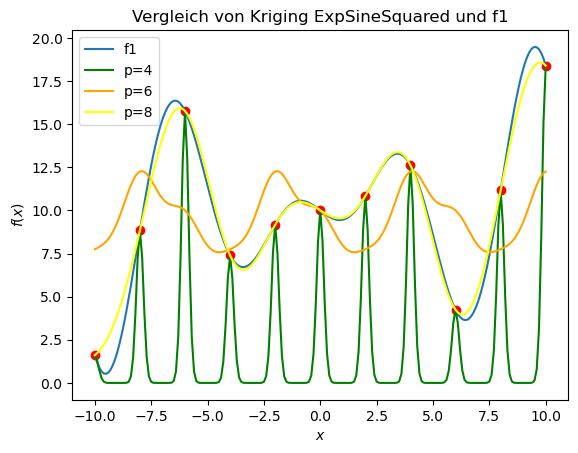

In [20]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, gpr_exp4.predict(X_Achse.reshape(201, 1)), c="green")
plt.plot(X_Achse, gpr_exp6.predict(X_Achse.reshape(201, 1)), c="orange")
plt.plot(X_Achse, gpr_exp8.predict(X_Achse.reshape(201, 1)), c="yellow")
plt.title("Vergleich von Kriging ExpSineSquared und f1")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'p=4', 'p=6', 'p=8'])

In [21]:
total_diff_exp4 = np.abs(gpr_exp4.predict(X_test.reshape(201, 1)) - comp_vals)
total_diff_exp6 = np.abs(gpr_exp6.predict(X_test.reshape(201, 1)) - comp_vals)
total_diff_exp8 = np.abs(gpr_exp8.predict(X_test.reshape(201, 1)) - comp_vals)

total_mean_exp4   = total_diff_exp4.mean()
squared_mean_exp4 = (total_diff_exp4**2).mean()

total_mean_exp6   = total_diff_exp6.mean()
squared_mean_exp6 = (total_diff_exp6**2).mean()

total_mean_exp8   = total_diff_exp8.mean()
squared_mean_exp8 = (total_diff_exp8**2).mean()

In [22]:
print(f'Kernel: RBF \t\t\tmtA: {total_mean_rbf : .2f}\tmqA: {squared_mean_rbf : .2f}\n')

print(f'Kernel: Matern\t nu: 0.5\tmtA: {total_mean_mat0 : .2f}\tmqA: {squared_mean_mat0 : .2f}')
print(f'Kernel: Matern\t nu: 1.5\tmtA: {total_mean_mat1 : .2f}\tmqA: {squared_mean_mat1 : .2f}')
print(f'Kernel: Matern\t nu: 2.5\tmtA: {total_mean_mat2 : .2f}\tmqA: {squared_mean_mat2 : .2f}\n')

print(f'Kernel: ESS\t  p: 4\t\tmtA: {total_mean_exp4 : .2f}\tmqA: {squared_mean_exp4 : .2f}')
print(f'Kernel: ESS\t  p: 6\t\tmtA: {total_mean_exp6 : .2f}\tmqA: {squared_mean_exp6 : .2f}')
print(f'Kernel: ESS\t  p: 8\t\tmtA: {total_mean_exp8 : .2f}\tmqA: {squared_mean_exp8 : .2f}')

Kernel: RBF 			mtA:  0.41	mqA:  0.45

Kernel: Matern	 nu: 0.5	mtA:  1.23	mqA:  2.73
Kernel: Matern	 nu: 1.5	mtA:  0.74	mqA:  1.07
Kernel: Matern	 nu: 2.5	mtA:  0.61	mqA:  0.79

Kernel: ESS	  p: 4		mtA:  7.97	mqA:  88.71
Kernel: ESS	  p: 6		mtA:  3.46	mqA:  18.13
Kernel: ESS	  p: 8		mtA:  0.41	mqA:  0.44


Das wohl beste Modell ist hier Kriging mit dem ExpSineSquared Kernel mit Parameter p=8. Nahezu identische Abweichungen weißt das Modell mit RBF-Kernel auf. Diese Beiden Modelle nähern die Funktion $f_1$ sehr gut an. <br>
Beim ExpSineSquared Kernel ist zu beobachten, dass das Modell mit $p=4$ stets den Wert 0 annimmt bis sich der X-Wert an einen Abstastpunkt annähert. Dann steigt die Modellfunktion an bis diese ein lokales Maximum im Abtastpunkt annimmt. Anschließend sinkt die Funktion wieder auf 0 herab. Daher ergeben sich sehr hohe Abweichungen der Werte für alle Punkte, die kein Abtastpunkt sind. Für $p=6$ nähert die Modellfunktion das Verhalten von $f_1$ schon besser an, allerdings liegen die Wert häufig noch überhalb bzw. unterhalb der Funktion. <br>
Die Modelle des Matern-Kernels weichen deutlich weniger von einander ab. Hier ist zu beobachten, dass die Funktionswert des Modells mit $\nu = 2.5$ stets zwischen der Funktion $f_1$ und der Modellfunktion des Modells mit Paramter $\nu = 0.5$ liegen. Alle drei Modelle laufen allerdings genau durch die Abtastpunkte.

### (3) Symbolische Regression

__Funktion der Parameter:__ <br> <br>
* Population Size: steht für die Anzahl Programme in jeder Generation. <br>
* Tournament Size: Steht für die Anzahl der Programme, die im Turnier um das Weiterkommen in die nächste Generation teilnehmen. <br>
* Generations: Anzahl Generationen, die erstellt werden. <br>
* Stoppkiterium: Minimaler Wert der Genauigkeitsmetrik, ab dem die Evolution gestoppt und das Programm angenommen wird, welches einen Genuigkeitswert kleiner oder gleich diesem Wert hat. <br>

In [102]:
func_sets = [['add', 'sub'] , ['mul', 'div'], ['add','mul'], ['add', 'sub','mul', 'div'], ['sin','cos'], ['add','mul','sin'], ['sub', 'mul', 'cos'], ['add','sub','mul','div','sin','cos']]

In [112]:
mean_total_diffs = np.zeros((8, 10))
mean_squared_diffs = np.zeros((8, 10))
for j in range(10):
    for i, fs in enumerate(func_sets):
        sym_reg = SymbolicRegressor(population_size=500, tournament_size=10, 
                                    generations=25, stopping_criteria=0.01, 
                                    n_jobs=-1, function_set=fs)
        sym_reg.fit(X, f1(X))
        preds = sym_reg.predict(X_test.reshape(201, 1))
        total_diff = np.abs(preds - comp_vals)
        mean_total_diffs[i][j] = total_diff.mean()
        mean_squared_diffs[i][j] = (total_diff**2).mean()

/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array w

{'whiskers': [<matplotlib.lines.Line2D at 0x7f553a37deb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f553a308430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f553a37dc10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f553a308970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f553a308c10>],
 'means': []}

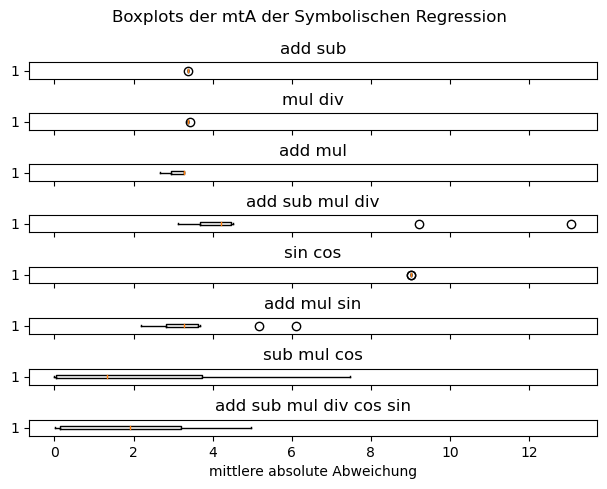

In [123]:
fig, ax = plt.subplots(8, sharex=True)
fig.suptitle('Boxplots der mtA der Symbolischen Regression')
fig.tight_layout(pad=1.5)
plt.xlabel('mittlere absolute Abweichung')
ax[0].set_title('add sub')
ax[0].boxplot(mean_total_diffs[0], vert=False)
ax[1].set_title('mul div')
ax[1].boxplot(mean_total_diffs[1], vert=False)
ax[2].set_title('add mul')
ax[2].boxplot(mean_total_diffs[2], vert=False)
ax[3].set_title('add sub mul div')
ax[3].boxplot(mean_total_diffs[3], vert=False)
ax[4].set_title('sin cos')
ax[4].boxplot(mean_total_diffs[4], vert=False)
ax[5].set_title('add mul sin')
ax[5].boxplot(mean_total_diffs[5], vert=False)
ax[6].set_title('sub mul cos')
ax[6].boxplot(mean_total_diffs[6], vert=False)
ax[7].set_title('add sub mul div cos sin')
ax[7].boxplot(mean_total_diffs[7], vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5538fbd2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5538fbd820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5538fbd040>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5538fbdd60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5538f4d040>],
 'means': []}

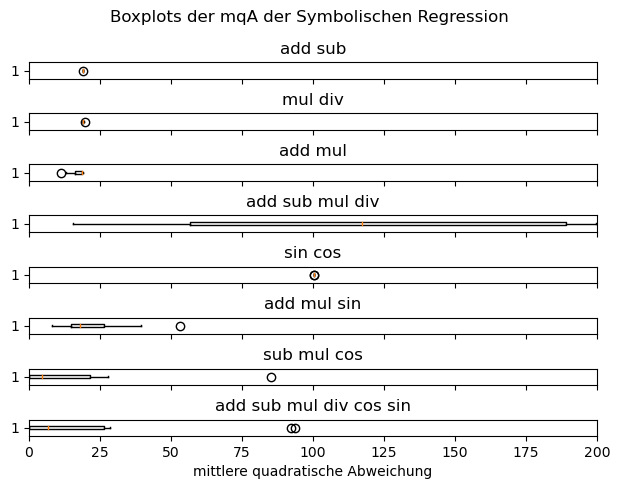

In [129]:
fig, ax = plt.subplots(8, sharex=True)
fig.suptitle('Boxplots der mqA der Symbolischen Regression')
fig.tight_layout(pad=1.5)
plt.xlabel('mittlere quadratische Abweichung')
plt.xlim(0, 200)
ax[0].set_title('add sub')
ax[0].boxplot(mean_squared_diffs[0], vert=False)
ax[1].set_title('mul div')
ax[1].boxplot(mean_squared_diffs[1], vert=False)
ax[2].set_title('add mul')
ax[2].boxplot(mean_squared_diffs[2], vert=False)
ax[3].set_title('add sub mul div')
ax[3].boxplot(mean_squared_diffs[3], vert=False)
ax[4].set_title('sin cos')
ax[4].boxplot(mean_squared_diffs[4], vert=False)
ax[5].set_title('add mul sin')
ax[5].boxplot(mean_squared_diffs[5], vert=False)
ax[6].set_title('sub mul cos')
ax[6].boxplot(mean_squared_diffs[6], vert=False)
ax[7].set_title('add sub mul div cos sin')
ax[7].boxplot(mean_squared_diffs[7], vert=False)

In den Boxplots ist zu erkennen, dass die Funktionsmenge $[sub, mul, cos]$ im mittel die geringste mittlere absolute und quadratische Abweichung aufweißt. Dabei handelt es sich um die Funktionsmenge die benötigt wird, um die Funktion $f_1$ genau nachbauen zu können. Die nächst beste Funktionsmenge ist $[add, sub, mul, div, sin, cos]$. Dies liegt daran, dass alle Funktionen die für eine genau rekonstruktion von $f_1$ benötigt werden in dieser Menge enthalten sind. Allerdings ist diese Menge im mittel etwas schlechter als die zuvor betrachtete, da auch Funktionen enthalten sind, welche nicht benötigt werden.

In [143]:
best_sym_reg = SymbolicRegressor(population_size=500, tournament_size=10, 
                                    generations=25, stopping_criteria=0.01, 
                                    n_jobs=-1, function_set=['sub', 'mul', 'cos'])
best_sym_reg.fit(X, f1(X))

/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SymbolicRegressor(function_set=['sub', 'mul', 'cos'], generations=25, n_jobs=-1,
                  population_size=500, stopping_criteria=0.01,
                  tournament_size=10)

In [145]:
print(best_sym_reg)

sub(sub(sub(0.900, -0.648), sub(mul(sub(-0.668, 0.513), sub(sub(0.900, sub(mul(sub(-0.668, 0.513), sub(sub(0.900, -0.648), sub(mul(sub(-0.668, 0.513), cos(0.853)), 0.937))), cos(cos(cos(0.193))))), sub(mul(cos(sub(sub(0.900, -0.648), cos(X0))), mul(X0, 0.882)), cos(cos(0.193))))), cos(cos(cos(0.193))))), sub(cos(cos(mul(mul(0.160, X0), sub(X0, X0)))), cos(0.513)))


In [147]:
# Option um den Syntaxbaum grafisch zu betrachten
graph = graphviz.Source(best_sym_reg._program.export_graphviz())
#graph

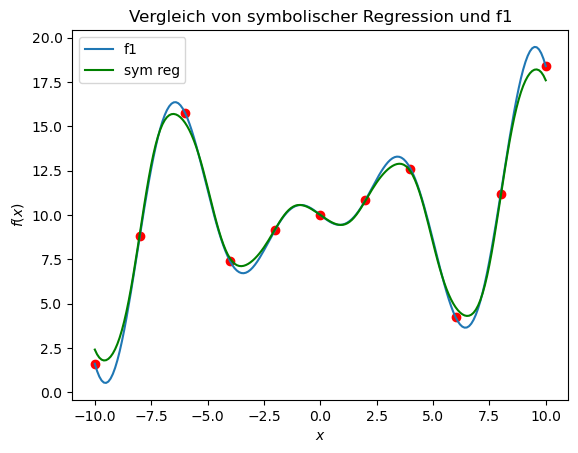

In [144]:
X_Achse = np.linspace(LOWER, UPPER, 201)
plt.plot(X_Achse, f1(X_Achse))
plt.plot(X_Achse, best_sym_reg.predict(X_Achse.reshape(201, 1)), c="green")
plt.title("Vergleich von symbolischer Regression und f1")
plt.scatter(X, f1(X), c="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(labels=['f1', 'sym reg'])

### (b) <br>
__Anmerkung:__ Für Kriging haben wir beim Lösen von (a) keine Funktion zur Generierung bzw. Anpassung der Modelle verwendet, also können wir diese auch nicht wieder verwenden. Daher implementieren wir diese Funktion hier erst bei (b). Diese könnte auch identisch für die Lösung von (a) verwendet werden.  

In [3]:
def f2(x): return 5 * np.min(x, axis=0) - 3 * x[0]

LOWER_X = 0
UPPER_X = 100
LOWER_Y = 30
UPPER_Y = 70

In [17]:
x = np.linspace(0, 100, 101)
y = np.random.normal(50, 7, size=100)

X, Y = np.meshgrid(x, y)
Z = 5 * np.min([X, Y], axis=0) - 3 * X

In [19]:
x_Achse = np.linspace(LOWER_X, UPPER_X, 101)
y_Achse = np.linspace(LOWER_Y, UPPER_Y, 41)

X_Achse, Y_Achse = np.meshgrid(x_Achse, y_Achse)
X_test = np.array(list(zip(X_Achse.flatten(), Y_Achse.flatten())))
comp_vals = 5 * np.min([X_Achse, Y_Achse], axis=0) - 3 * X_Achse

### (1) ploynomielle Regression

In [18]:
poly_1  = poly_model_generator(f2, 1,  xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)
poly_2  = poly_model_generator(f2, 2,  xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)
poly_5  = poly_model_generator(f2, 5,  xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)
poly_10 = poly_model_generator(f2, 10, xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)
poly_15 = poly_model_generator(f2, 15, xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)

In [21]:
degrees = [1, 2, 5, 10, 15]
for d in degrees:
    poly_model = poly_model_generator(f1, d, xs=np.array(list(zip(X.flatten(), Y.flatten()))), ys=Z.flatten(), dim=2)
    model_vals = poly_model(X_test)
    total_diff = np.abs(model_vals - comp_vals.flatten())
    total_mean = total_diff.mean()
    squared_mean = (total_diff**2).mean()
    print(f'Grade: {d}\tmittlere totale Abweichung: {total_mean : .2f}\tmittlere quadratische Abweichung: {squared_mean : .2f}')

Grade: 1	mittlere totale Abweichung:  35.05	mittlere quadratische Abweichung:  1760.89
Grade: 2	mittlere totale Abweichung:  9.40	mittlere quadratische Abweichung:  136.97
Grade: 5	mittlere totale Abweichung:  4.96	mittlere quadratische Abweichung:  42.24
Grade: 10	mittlere totale Abweichung:  2.00	mittlere quadratische Abweichung:  11.47
Grade: 15	mittlere totale Abweichung:  10.04	mittlere quadratische Abweichung:  1143.05


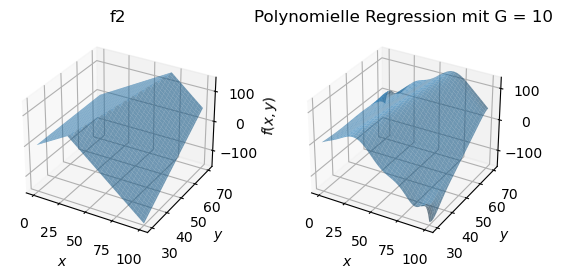

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title('f2')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$f(x,y)$')
ax2.set_title('Polynomielle Regression mit G = 10')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.plot_surface(X_Achse, Y_Achse, comp_vals, alpha=0.6)
ax2.plot_surface(X_Achse, Y_Achse, poly_10(X_test.reshape(-1,2)).reshape(41, 101), alpha=0.6)
fig.tight_layout(pad=5)

Grafisch ist zu erkennen, dass das polynomielle Regressionsmodell die Funktion $f_2$ annähernd rekonstruiert hat. Allerdings weißt die Funktion $f_2$ eine Spitze auf, welche beim Regressionsmodell abgerundet ist. Außerdem liegen an den Rändern der Wertebereich bei diesem erneut Schwankungen vor (wie bereits bei (a) beobachtet). Das Modell weißt eine mittlere quadratische Abweichung von $11.47$ auf und ist somit etwas schlechter als das beste polynomielle Regressionsmodell in (a). Außerdem ist zu beobachten, dass das beste Modell in (a) den Grad $5$ verwendet hat, während das beste Modell hier den Grad $10$ aufweist. 

### (2) Kriging

In [26]:
# Wenn dim=1, dann kann diese Funktion für (a) verwendet werden
def kriging_model_generator(xs, ys, kernel, dim=2, **kwargs):
    gpr_model = GaussianProcessRegressor(kernel(**kwargs))
    gpr_model.fit(xs, ys)
    return lambda x: gpr_model.predict(np.array(x).reshape(-1, dim)).flatten()

In [36]:
def find_best_kriging(xs, ys):
    best_abs_diff = np.Inf
    best_sq_diff = np.Inf
    best_kernel = None
    best_param = None

    x_Achse = np.linspace(LOWER_X, UPPER_X, 101)
    y_Achse = np.linspace(LOWER_Y, UPPER_Y, 41)
    X_Achse, Y_Achse = np.meshgrid(x_Achse, y_Achse)
    X_test = np.array(list(zip(X_Achse.flatten(), Y_Achse.flatten())))

    comp_vals = 5 * np.min([X_Achse, Y_Achse], axis=0) - 3 * X_Achse
    
    try: # RBF
        current_kernel = "RBF"
        model = kriging_model_generator(xs, ys, kernel=RBF)

        preds = model(X_test)
        abs_diff = np.abs(comp_vals.flatten() - preds)
        mean_abs_diff = abs_diff.mean()
        mean_sq_diff = (abs_diff**2).mean()
        if mean_abs_diff < best_abs_diff:
            best_abs_diff = mean_abs_diff
            best_sq_diff = mean_sq_diff
            best_kernel = current_kernel

    except np.linalg.LinAlgError:
        print(f'Der Kernel {current_kernel} ist nicht anwendbar')

    try: # Matern
        current_kernel = "Matern"
        nus = [0.5, 1.5, 2.5]
        for nu in nus:
            model = kriging_model_generator(xs, ys, kernel=Matern, nu=nu)

            preds = model(X_test)
            abs_diff = np.abs(comp_vals.flatten() - preds)
            mean_abs_diff = abs_diff.mean()
            mean_sq_diff = (abs_diff**2).mean()
            if mean_abs_diff < best_abs_diff:
                best_abs_diff = mean_abs_diff
                best_sq_diff = mean_sq_diff
                best_kernel = current_kernel
                best_param = nu
        
    except np.linalg.LinAlgError:
        print(f'Der Kernel {current_kernel} ist nicht anwendbar')

    try: # ExpSineSquared
        current_kernel = "ExpSineSquared"
        ps = [4, 6, 8]
        for p in ps:
            model = kriging_model_generator(xs, ys, kernel=ExpSineSquared, periodicity=p)

            preds = model(X_test)
            abs_diff = np.abs(comp_vals.flatten() - preds)
            mean_abs_diff = abs_diff.mean()
            mean_sq_diff = (abs_diff**2).mean()
            if mean_abs_diff < best_abs_diff:
                best_abs_diff = mean_abs_diff
                best_sq_diff = mean_sq_diff
                best_kernel = current_kernel
                best_param = p

    except np.linalg.LinAlgError:
        print(f'Der Kernel {current_kernel} ist nicht anwendbar')
        
    return {'kernel' : best_kernel, 'param' : best_param, 'mtA' : best_abs_diff, 'msA' : best_sq_diff}

In [37]:
find_best_kriging(np.array(list(zip(X.flatten(), Y.flatten()))), Z.flatten())

/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tobi/anaconda3/envs/PO/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Der Kernel ExpSineSquared ist nicht anwendbar


{'kernel': 'Matern',
 'param': 0.5,
 'mtA': 0.677539140590192,
 'msA': 5.331582559737829}

Der ExpSineSquared Kernel kann nicht verwendet werden. Das beste Kriging-Modell für $f_2$ verwendet den Matern Kernel mit dem Parameter $\nu = 0.5$.

In [38]:
best_kriging_model = kriging_model_generator(np.array(list(zip(X.flatten(), Y.flatten()))), Z.flatten(), 
                                             kernel=Matern, nu=0.5)

In [40]:
preds = best_kriging_model(X_test)
abs_diff = np.abs(comp_vals.flatten() - preds)
mean_abs_diff = abs_diff.mean()
mean_sq_diff = (abs_diff**2).mean()

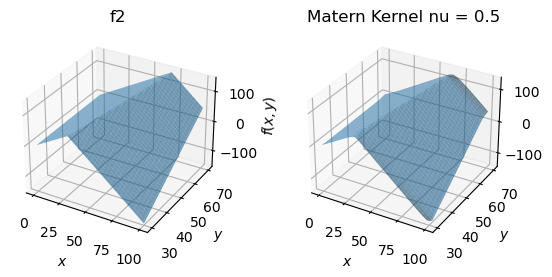

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title('f2')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$f(x,y)$')
ax2.set_title('Matern Kernel nu = 0.5')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.plot_surface(X_Achse, Y_Achse, comp_vals, alpha=0.6)
ax2.plot_surface(X_Achse, Y_Achse, best_kriging_model(X_test.reshape(-1,2)).reshape(41, 101), alpha=0.6)
fig.tight_layout(pad=5)

In [41]:
print(f'Kriging mit Matern Kernel mit nu = 0.5: \n')
print(f'mittlere absolute Abweichung: {mean_abs_diff : .2f}\t\tmittlere quadratische Abweichung: {mean_sq_diff:.2f}')

Kriging mit Matern Kernel mit nu = 0.5: 

mittlere absolute Abweichung:  0.68		mittlere quadratische Abweichung: 5.33


Grafisch sieht die Funktionsannäherung durch Kriging recht gut aus. Allerdings ist eine durchschnittliche quadratische Abweichung von etwa 5.33 festzustellen. Kriging scheint die Funktion hier schlechter anzunähern als in (a). 

### (3) symbolische Regression

Ich verwende hier als Funktionsmenge $[sub, mul, min]$, da die Funktion $f_2$ aus genau diesen drei Funktion
zusammengesetzt ist. In (a) hat sich für $f_1$ gezeigt, dass die beste Funktionsmenge genau aus den Funktionen bestand, die benötigt werden um $f_1$ rekonstruieren zu können. Daher nehme ich das selbe für $f_2$ an.

In [ ]:
func_set = ['sub', 'mul', 'min']
best_sym_reg = SymbolicRegressor(population_size=1000, tournament_size=10, 
                                    generations=50, stopping_criteria=0.01, 
                                    n_jobs=-1, function_set=func_set)
best_sym_reg.fit(np.array(list(zip(X.flatten(), Y.flatten()))), Z.flatten())

SymbolicRegressor(function_set=['sub', 'mul', 'min'], generations=50, n_jobs=-1,
                  stopping_criteria=0.01, tournament_size=10)

In [ ]:
print(best_sym_reg)

min(sub(sub(min(X0, X1), sub(X0, sub(min(X0, X1), sub(X0, sub(min(X0, X1), sub(X0, min(X1, X0))))))), sub(mul(0.414, mul(mul(0.663, X0), sub(X0, X0))), min(X1, X0))), mul(X0, X1))


In [ ]:
total_diff = np.abs(best_sym_reg.predict(X_test.reshape(-1, 2)) - comp_vals.flatten())

mean_absolute_diff = total_diff.mean()
mean_squared_diff  = (total_diff**2).mean()

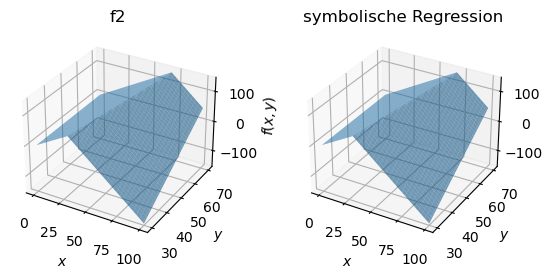

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title('f2')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$f(x,y)$')
ax2.set_title('symbolische Regression')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.plot_surface(X_Achse, Y_Achse, comp_vals, alpha=0.6)
ax2.plot_surface(X_Achse, Y_Achse, best_sym_reg.predict(X_test.reshape(-1,2)).reshape(41, 101), alpha=0.6)
fig.tight_layout(pad=5)

In [ ]:
print(f'Symbolische Regression mit population_size = 1000 und generations = 50:\n')
print(f'mittlere absolute Abweichung: {mean_absolute_diff : .2f}\t\tmittlere quadratische Abweichung: {mean_squared_diff:.2f}')

Symbolische Regression mit population_size = 1000 und generations = 50:

mittlere absolute Abweichung:  0.00		mittlere quadratische Abweichung: 0.00


Die symbolische Regression mit der Funktionsmenge $[sub, mult, min]$ und einer population_size von $1000$ und einer Anzahl von Generationen von $50$ kann die Funktion $f_2$ nahezu perfekt simulieren.